In [0]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

4/0wHUZ-XzVRMJlglaIqfC4RxgEfL7qhY9VU2OPUjQ6FEWvR9Bog21EHw

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
%ls content/drive/My\ Drive

ls: cannot access 'content/drive/My Drive': No such file or directory


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
DATA = np.load('/content/drive/My Drive/preprocess/training_data.npy', allow_pickle=True)
DATA.shape

(57985, 2)

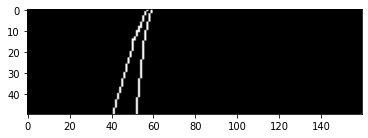

In [30]:
plt.imshow(DATA[0][0], cmap='gray')

In [31]:
X = np.array(DATA[:, 0])
Y = np.array(DATA[:, 1])

X.shape

(57985,)

In [0]:
img_shape = X[0].shape

In [0]:
#  features = (json['user_angle'], json['user_throttle'], json['distance'], json['timestamp'])

targets = [x[0] for x in Y] # only angle
targets = np.array(targets)

In [34]:
X = np.concatenate(X).reshape(-1, *img_shape)
X.shape

(57985, 50, 160)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
      X, targets, test_size=0.33, random_state=42)

In [0]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """
    __initialized = False
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset)), leave=True, position=0):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [
            torch.stack(ts) for ts in zip(*batches)
        ]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [47]:
batch_size = 128

data_loaders = {
    'train': InMemDataLoader(
        list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True),
    'test': InMemDataLoader(
        list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)
}

100%|██████████| 19136/19136 [00:00<00:00, 41451.35it/s]


In [48]:
'''
batch_size = 128

compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    list(zip(X_train, y_train)),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    list(zip(X_test, y_test)),
    batch_size=batch_size,
    shuffle=True,
)

'''

'\nbatch_size = 128\n\ncompose = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize((0.5,), (0.5,))\n])\n\ntrain_loader = torch.utils.data.DataLoader(\n    list(zip(X_train, y_train)),\n    batch_size=batch_size,\n    shuffle=True,\n)\n\ntest_loader = torch.utils.data.DataLoader(\n    list(zip(X_test, y_test)),\n    batch_size=batch_size,\n    shuffle=True,\n)\n\n'

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(50*160, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, X):
        X = X.view(X.size(0), -1)
        out = self.linear(X)
        return out
    
    def loss(self, Out, Targets):
        loss = torch.sum((Out - Targets) ** 2)
        return loss / Out.size(0)

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        h1 = 16
        h2 = 32
        kernel = (5, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=h1, kernel_size=kernel,
                      stride=1, padding=1),
            nn.BatchNorm2d(num_features=h1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=h1, out_channels=h2, kernel_size=kernel,
                      stride=1, padding=1),
            nn.BatchNorm2d(num_features=h2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        
        cnn_output_shape = 13376
        self.linear = nn.Sequential(
            nn.Linear(cnn_output_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 1),
            nn.Tanh()
        )

    def forward(self, X):
        out = self.conv(X)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def loss(self, Out, Targets):
        loss = torch.sum((Out - Targets) ** 2)
        return loss / Out.size(0)

In [0]:
l_rate = 0.005
n_epochs = 100
n_batches = X_train.shape[0] // batch_size

In [59]:
model = CNN()
# model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

model

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=13376, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=1, bias=True)
    (4): Tanh()
  )
)

In [60]:
model.train()
model.to(device)

for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)
            

try:
    for i in range(n_epochs):
        model.train()
        # pbar = tqdm(desc=f'Epoch: {i}', position=0, leave=True, total=n_batches)

        training_loss = 0
        num_batches = 0
        for images, y in data_loaders['train']:
            images = images.to(device)
            y = y.to(device)

            # pbar.update(1)

            flatten_images = images
            a, b, c = images.size()
            flatten_images = images.reshape(a, 1, b, c)

            z = model(flatten_images.float()) 
            loss = model.loss(z, y)
            training_loss += loss
            num_batches += 1
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    

        # pbar.close()
        model.eval()
        
        valid_loss = 0
        num_examples = 0
        with torch.no_grad():
            for images, y in data_loaders['test']:
                images = images.to(device)
                y = y.to(device)

                z = model(flatten_images.float()) 
                loss = model.loss(z, y)

                valid_loss += loss
                num_examples += 1
         
        # clear_output(True)
        print(f'Epoch: {i + 1}/{n_epochs} | Training loss: {training_loss / num_batches:.4f} | Val loss: {valid_loss / num_examples:.4f}')
   
    
except KeyboardInterrupt:
    pass

Epoch: 1/5 | Training loss: 20.5334 | Val loss: 17.1575
Epoch: 2/5 | Training loss: 16.8389 | Val loss: 16.3211
Epoch: 3/5 | Training loss: 16.4319 | Val loss: 16.2919
Epoch: 4/5 | Training loss: 16.3686 | Val loss: 16.3324
Epoch: 5/5 | Training loss: 16.3439 | Val loss: 16.2659


In [86]:
for x, y in data_loaders['train']:
    print(x.shape, y.shape)
    break

torch.Size([128, 50, 160]) torch.Size([128])


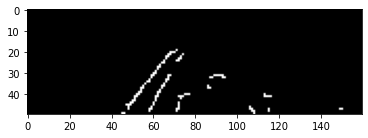

Model: tensor([[-0.0733]], device='cuda:0', grad_fn=<TanhBackward>) ||| Gro: -0.12333333333333334


KeyboardInterrupt: ignored

In [88]:
import time
for _ in range(1000):
    clear_output(True)
    tmp = next(iter(data_loaders['train']))
    x = tmp[0][0].detach().cpu()
    y = tmp[1][0].detach().cpu()

    plt.imshow(x, cmap='gray')
    plt.show()
    x = x.reshape(1, 1, *x.shape)
    x = x.to(device)
    print(f'Model: {model(x.float())} ||| Gro: {y}')
    time.sleep(2)